# Курсовой проект по курсу Data Science

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, RandomizedSearchCV 

import matplotlib
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer


%matplotlib inline

In [2]:
def load_dataset(path):
    return pd.read_csv(path) #.set_index('Id')

def display_df(df, lines = 10):
    display(df.tail(-lines) if lines < 0 else df.head(lines))
    print(df.shape)
    display(df.describe().T)
    display(df.isnull().sum())
      

**Пути к директориям и файлам**

In [3]:
TRAIN_DATASET_PATH = 'datasets/project_task/train.csv'
TEST_DATASET_PATH = 'datasets/project_task/test.csv'
TEST_PREDICTION_PATH = 'datasets/project_task/prediction.csv'

**Режим исполнения**

In [4]:
test_from_train = False
use_validation = False
use_cross_validation = False
use_parameter_search = False

**Загрузка данных**

In [5]:
train_df = load_dataset(TRAIN_DATASET_PATH)
test_df = load_dataset(TEST_DATASET_PATH)

**Функции подготовки данных**

In [6]:
def aggregate_col_name(col, agg, groupby_cols):
    return '_'.join([col, agg, 'by'] + groupby_cols)
                    

def get_aggregates0(df, col, groupby_cols, agg):
    return df.groupby(groupby_cols, as_index=False).agg({col: agg})\
             .rename(columns={col: aggregate_col_name(col, agg, groupby_cols)})
    
    
def get_aggregates(df, col, groupby_cols, agg = 'median'):
    agg_col_name = aggregate_col_name(col, agg, groupby_cols)        
    if not preparing_train_df and agg_col_name in get_train_df(df).columns:
        return get_aggregates0(get_train_df(df), agg_col_name, groupby_cols, 'median')\
                 .rename(columns={aggregate_col_name(agg_col_name, 'median', groupby_cols): agg_col_name})
    else:
        return get_aggregates0(df, col, groupby_cols, agg)
    

def reset_to_nan(df, col, min_val, max_val):
    df.loc[(df[col] < min_val) | (df[col] >= max_val), col] = np.nan
    return df
    

def update_nans_from_df(df, col, to_col, df2, join_cols, def_val = None):
    to_col_copy = None
    if to_col in df.columns:
        to_col_copy = to_col + '_____tmp'
        df = df.rename(columns={ to_col: to_col_copy})
    df = df.merge(df2[ [to_col] + join_cols], on = join_cols, how='left')
    df.loc[df[col].isnull(), col] = df.loc[df[col].isnull(), to_col]
    if def_val is not None:
        df.loc[df[col].isnull(), col] = def_val
    df = df.drop(columns = [to_col])
    if to_col_copy is not None and to_col_copy in df.columns:
        df = df.rename(columns={ to_col_copy: to_col})
    return df


def get_train_df(df):
    return df if preparing_train_df else train_df


def fix_nans(df, col, groupby_cols = None):
    if groupby_cols is not None and len(groupby_cols) > 0: 
        agg_col_name = aggregate_col_name(col, 'median', groupby_cols)
        m = get_aggregates(get_train_df(df), col, groupby_cols, 'median')
        df = update_nans_from_df(df, col, agg_col_name, m, groupby_cols, get_train_df(df)[col].median())
    df.loc[df[col].isnull(), col] = get_train_df(df)[col].median()
    return df
                    

def fix_areas(df):
    df = reset_to_nan(df, 'Rooms', 1, 10)
    df = fix_nans(df, 'Rooms')

    df = reset_to_nan(df, 'Square', 10, 1000)

    df = add_aggregates(df, 'Square', ['Rooms'])
    square_outliers = df[df['Square'].isnull() | (df['Square'] < df['Square_median_by_Rooms'] * 0.2)].index
    df.loc[square_outliers, 'Square'] = df.loc[square_outliers, 'Square_median_by_Rooms']

    df = fix_nans(df, 'Square', ['Rooms'])

    square_outliers = df[(df['KitchenSquare'] < 5) | (df['LifeSquare'] < 1) | (df['KitchenSquare'] + df['LifeSquare'] > df['Square'])].index
    df.loc[square_outliers, 'KitchenSquare'] = np.nan
    df.loc[square_outliers, 'LifeSquare'] = np.nan
    
    df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df.loc[df['LifeSquare'].isnull(), 'Square'] * 0.7
    df.loc[df['KitchenSquare'].isnull(), 'KitchenSquare'] = df.loc[df['KitchenSquare'].isnull(), 'Square'] * 0.2
    
    return df
    

def fix_floor(df):
    df = reset_to_nan(df, 'Floor', 0, 100)
    df = reset_to_nan(df, 'HouseFloor', 1, 100)

    df.loc[df['HouseFloor'].isnull(), 'HouseFloor'] = df.loc[df['HouseFloor'].isnull(), 'Floor'] + 1
    df = fix_nans(df, 'HouseFloor')
    floor_outliers = df[df['Floor'] > df['HouseFloor']].index
    df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
    return df


def fix_year(df):
    df = fix_nans(df, 'HouseYear', ['DistrictId'])
    df['HouseYear'] = df['HouseYear'] % 1000
    in20 = df[df['HouseYear'] < 100].index
    in19 = df[df['HouseYear'] >= 900].index
    df.loc[in20, 'HouseYear'] = df.loc[in20, 'HouseYear'] + 2000 
    df.loc[in19, 'HouseYear'] = df.loc[in19, 'HouseYear'] + 1000

    df = reset_to_nan(df, 'HouseYear', 1850, 2022)
    df = fix_nans(df, 'HouseYear', ['DistrictId'])

    return df


imputer = None
def use_imputer(df):
    global imputer
    df = reset_to_nan(df, 'Square', 10, 1000)
    if preparing_train_df:
        imputer = IterativeImputer(max_iter=100, min_value=0)
        imputer.fit_transform(get_train_df(df)[old_feature_names])
    df = df.reset_index(drop=True)
    imp_df = pd.DataFrame(imputer.transform(df[old_feature_names]), columns = old_feature_names)
    df.loc[:,['Square', 'LifeSquare', 'Healthcare_1', 'Helthcare_2']] = \
            imp_df.loc[:,['Square', 'LifeSquare', 'Healthcare_1', 'Helthcare_2']]
    return df


def fix_values(df):
    
#    df = use_imputer(df) # не помогло
    
    df = fix_areas(df)

    df = fix_floor(df)
    df = fix_year(df)

    df = fix_nans(df, 'Healthcare_1', ['DistrictId'])
    df = fix_nans(df, 'Helthcare_2', ['DistrictId'])

    df = fix_nans(df, 'Social_1', ['DistrictId'])
    df = fix_nans(df, 'Social_2', ['DistrictId'])
    df = fix_nans(df, 'Social_3', ['DistrictId'])
    
    df = fix_nans(df, 'Ecology_1', ['DistrictId'])
    df = fix_nans(df, 'Shops_1', ['DistrictId'])

    return df


def add_aggregates(df, col, groupby_cols, agg = 'median'):
    df = df.merge(get_aggregates(get_train_df(df), col, groupby_cols, agg), on=groupby_cols, how='left')
    df = fix_nans(df, aggregate_col_name(col, agg, groupby_cols), groupby_cols[:-1])
    return df


def add_new_values(df):
    df['Ecology_2_bin'] = df['Ecology_2'].replace({'A':0, 'B':1}).astype(float)
    df['Ecology_3_bin'] = df['Ecology_3'].replace({'A':0, 'B':1}).astype(float)
    df['Shops_2_bin'] = df['Shops_2'].replace({'A':0, 'B':1}).astype(float)

    df = fix_nans(df, 'Ecology_2_bin')
    df = fix_nans(df, 'Ecology_3_bin')
    df = fix_nans(df, 'Shops_2_bin')

    district_size = get_train_df(df)['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})    
    df = df.merge(district_size, on='DistrictId', how='left')    
    df = fix_nans(df, 'DistrictSize')
    
   
    df['FloorValue'] = df.apply(lambda r: 0 if r['Floor'] == 1 else 1 if r['Floor'] == r['HouseFloor'] else 1 + r['Floor'] / r['HouseFloor'], axis=1)
    
    if preparing_train_df:
        df['PricePerSquare'] = df['Price'] / df['Square']    
        
    df = add_aggregates(df, 'Price', ['Rooms'], agg='mean')
    df = add_aggregates(df, 'Price', ['Rooms'])
    df = add_aggregates(df, 'PricePerSquare', ['Rooms'], agg='mean')
    df = add_aggregates(df, 'PricePerSquare', ['Rooms'])

    df = add_aggregates(df, 'Price', ['DistrictId'], agg='mean')
    df = add_aggregates(df, 'Price', ['DistrictId'])
    df = add_aggregates(df, 'PricePerSquare', ['DistrictId'], agg='mean')
    df = add_aggregates(df, 'PricePerSquare', ['DistrictId'])

    return df
    
    
def prepare_dataset(df):
    df = df.copy()
    df = fix_values(df)
    df = add_new_values(df)
    return df
    




**Выбор признаков**

In [7]:
old_feature_names = [
                 'Rooms', 
                 'Square', 
                 'LifeSquare', 
                 'KitchenSquare', 
                 'Floor', 
                 'HouseFloor', 
                 'HouseYear',
                 'Ecology_1', 
                 'Social_1', 
                 'Social_2', 
                 'Social_3',
                 'Healthcare_1', 
                 'Helthcare_2', 
                 'Shops_1'
               ]

new_feature_names = [
                      'DistrictSize', 
                      'Ecology_2_bin', 
                      'Ecology_3_bin',  
                      'Shops_2_bin', 
                      'FloorValue',

                      'PricePerSquare_mean_by_DistrictId',
    
#                    'Price_median_by_Rooms', 
#                    'Price_mean_by_Rooms', 
#                    'PricePerSquare_median_by_Rooms',
#                    'PricePerSquare_mean_by_Rooms',
#                    'Price_median_by_DistrictId', 
#                    'PricePerSquare_median_by_DistrictId',
#                    'Price_mean_by_DistrictId', 
                    ]

feature_names = old_feature_names + new_feature_names

target_name = 'Price'

In [8]:
# Отделяем тестовые тестовые данные от тренировочного набора на самом раннем этапе
# для отладки и настройки подготовки данных и модели, максимально близкой к реальному режиму
if test_from_train:
    train_df, test_df = train_test_split(train_df, test_size=0.3, shuffle=True, random_state=21)

**Предварительный просмотр данных**

In [9]:
display_df(train_df)
display_df(test_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B,296021.204377
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.795999
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,B,B,6,1437,3,NaN,0,2,B,95380.220993


(10000, 20)


,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
5,7633,53,1.0,40.675627,NaN,1.0,21,21.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
6,13329,23,2.0,68.099538,64.843025,1.0,2,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
7,5502,32,2.0,48.193897,32.857644,6.0,5,14.0,1972,0.135650,B,B,46,7960,6,350.0,3,11,B
8,4220,96,3.0,72.277106,45.968758,9.0,17,17.0,1997,0.041116,B,B,53,14892,4,NaN,1,4,B
9,11538,6,3.0,80.219400,47.660260,9.0,13,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B


(5000, 19)


,count,mean,std,min,25%,50%,75%,max
Id,5000.0,8412.595400,4832.674037,1.000000,4221.750000,8320.500000,12598.250000,16795.000000
DistrictId,5000.0,51.279200,44.179466,0.000000,21.000000,37.000000,77.000000,212.000000
Rooms,5000.0,1.910000,0.838594,0.000000,1.000000,2.000000,2.000000,17.000000
Square,5000.0,56.449500,19.092787,1.378543,41.906231,52.921340,66.285129,223.453689
LifeSquare,3959.0,36.158810,17.825287,0.333490,23.092026,32.925087,45.174091,303.071094
KitchenSquare,5000.0,5.976800,9.950018,0.000000,1.000000,6.000000,9.000000,620.000000
Floor,5000.0,8.632000,5.483228,1.000000,4.000000,7.000000,12.000000,78.000000
HouseFloor,5000.0,12.601000,6.789213,0.000000,9.000000,12.000000,17.000000,99.000000
HouseYear,5000.0,1984.392600,18.573149,1908.000000,1973.000000,1977.000000,2000.000000,2020.000000
Ecology_1,5000.0,0.119874,0.120070,0.000000,0.019509,0.072158,0.195781,0.521867


Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

**Подготовка данных**

In [10]:
preparing_train_df = True    
train_df = prepare_dataset(train_df)
preparing_train_df = False
test_df = prepare_dataset(test_df)

In [11]:
display_df(train_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,FloorValue,PricePerSquare,Price_mean_by_Rooms,Price_median_by_Rooms,PricePerSquare_mean_by_Rooms,PricePerSquare_median_by_Rooms,Price_mean_by_DistrictId,Price_median_by_DistrictId,PricePerSquare_mean_by_DistrictId,PricePerSquare_median_by_DistrictId
0,14038,35,2.0,47.981561,29.442751,6.000000,7.0,9.0,1969.0,0.089040,...,1.777778,3854.958571,215205.837882,200332.511658,3884.936267,3899.252990,219720.055820,203602.408898,4384.628620,4358.274853
1,15053,41,3.0,65.683640,40.049543,8.000000,7.0,9.0,1978.0,0.000070,...,1.777778,4567.491245,289337.962452,268723.157677,3812.882099,3853.920526,225918.593255,210694.850106,4293.480295,4437.304072
2,4765,53,2.0,44.947953,31.463567,8.989591,8.0,12.0,1968.0,0.049637,...,1.666667,4915.149522,215205.837882,200332.511658,3884.936267,3899.252990,255736.155162,245978.794474,4835.401165,4845.919064
3,5809,58,2.0,53.352981,37.347087,10.670596,8.0,17.0,1977.0,0.437885,...,1.470588,3291.591637,215205.837882,200332.511658,3884.936267,3899.252990,162287.311374,151557.904767,3021.675025,2949.975415
4,10783,99,1.0,39.649192,23.776169,7.000000,11.0,12.0,1976.0,0.012339,...,1.916667,3788.892642,159850.800729,154979.497993,3943.969813,3946.150889,184157.448198,178829.166450,3938.329635,3992.031265
5,12915,59,3.0,80.384479,46.683720,12.000000,5.0,17.0,2011.0,0.309479,...,1.294118,2685.822560,289337.962452,268723.157677,3812.882099,3853.920526,322216.314863,318772.374740,4746.494431,4736.631611
6,14549,154,2.0,62.254114,37.160377,7.000000,3.0,5.0,1960.0,0.460556,...,1.600000,4755.046491,215205.837882,200332.511658,3884.936267,3899.252990,278770.348714,279053.933157,5457.091839,5445.489427
7,11993,74,2.0,80.312926,56.219048,16.062585,14.0,15.0,1977.0,0.075779,...,1.933333,2754.776456,215205.837882,200332.511658,3884.936267,3899.252990,210696.110719,195610.960042,3355.343060,3319.318045
8,5172,1,2.0,64.511437,45.158006,12.902287,9.0,17.0,1977.0,0.007122,...,1.529412,3551.351598,215205.837882,200332.511658,3884.936267,3899.252990,187805.401737,183663.443595,3214.073587,3251.202203
9,8649,23,1.0,46.461409,18.915552,8.000000,13.0,17.0,2014.0,0.075779,...,1.764706,2052.891285,159850.800729,154979.497993,3943.969813,3946.150889,126840.385894,113789.561738,2284.108677,2273.498737


(10000, 35)


,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,16798.000000
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,209.000000
Rooms,10000.0,1.888800,0.812096,1.000000,1.000000,2.000000,2.000000,6.000000
Square,10000.0,56.376690,20.983252,16.117154,41.783674,52.539538,65.925548,641.065193
LifeSquare,10000.0,36.213149,15.082964,2.228592,26.246759,33.163258,45.055731,448.745635
KitchenSquare,10000.0,9.419538,4.175603,3.223431,7.000000,8.771214,11.000000,128.213039
Floor,10000.0,7.478000,5.095715,1.000000,3.000000,6.000000,11.000000,42.000000
HouseFloor,10000.0,12.868300,6.439527,1.000000,9.000000,14.000000,17.000000,99.000000
HouseYear,10000.0,1984.866300,18.412271,1910.000000,1974.000000,1977.000000,2001.000000,2020.000000
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,0.521867


Id                                     0
DistrictId                             0
Rooms                                  0
Square                                 0
LifeSquare                             0
KitchenSquare                          0
Floor                                  0
HouseFloor                             0
HouseYear                              0
Ecology_1                              0
Ecology_2                              0
Ecology_3                              0
Social_1                               0
Social_2                               0
Social_3                               0
Healthcare_1                           0
Helthcare_2                            0
Shops_1                                0
Shops_2                                0
Price                                  0
Square_median_by_Rooms                 0
Ecology_2_bin                          0
Ecology_3_bin                          0
Shops_2_bin                            0
DistrictSize    

In [12]:
display_df(test_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,DistrictSize,FloorValue,Price_mean_by_Rooms,Price_median_by_Rooms,PricePerSquare_mean_by_Rooms,PricePerSquare_median_by_Rooms,Price_mean_by_DistrictId,Price_median_by_DistrictId,PricePerSquare_mean_by_DistrictId,PricePerSquare_median_by_DistrictId
0,725,58,2.0,49.882643,33.432782,6.000000,6.0,14.0,1972.0,0.310199,...,179.0,1.428571,215205.837882,200332.511658,3884.936267,3899.252990,162287.311374,151557.904767,3021.675025,2949.975415
1,15856,74,2.0,69.263183,48.484228,13.852637,1.0,1.0,1977.0,0.075779,...,114.0,0.000000,215205.837882,200332.511658,3884.936267,3899.252990,210696.110719,195610.960042,3355.343060,3319.318045
2,5480,190,1.0,13.597819,9.518473,2.719564,2.0,5.0,1909.0,0.000000,...,7.0,1.400000,159850.800729,154979.497993,3943.969813,3946.150889,471966.746348,526438.458919,7919.443196,8645.171143
3,15664,47,2.0,73.046609,51.940842,9.000000,22.0,22.0,2007.0,0.101872,...,97.0,1.000000,215205.837882,200332.511658,3884.936267,3899.252990,213625.761375,196429.659238,4116.345095,4181.963615
4,14275,27,1.0,47.527111,33.268977,9.505422,17.0,17.0,2017.0,0.072158,...,851.0,1.000000,159850.800729,154979.497993,3943.969813,3946.150889,156046.416277,146171.433190,2764.099125,2759.061809
5,7633,53,1.0,40.675627,28.472939,8.135125,21.0,21.0,1977.0,0.049637,...,174.0,1.000000,159850.800729,154979.497993,3943.969813,3946.150889,255736.155162,245978.794474,4835.401165,4845.919064
6,13329,23,2.0,68.099538,47.669677,13.619908,2.0,17.0,1977.0,0.075779,...,565.0,1.117647,215205.837882,200332.511658,3884.936267,3899.252990,126840.385894,113789.561738,2284.108677,2273.498737
7,5502,32,2.0,48.193897,32.857644,6.000000,5.0,14.0,1972.0,0.135650,...,34.0,1.357143,215205.837882,200332.511658,3884.936267,3899.252990,256669.755050,234647.811956,5008.861902,5067.192463
8,4220,96,3.0,72.277106,45.968758,9.000000,17.0,17.0,1997.0,0.041116,...,71.0,1.000000,289337.962452,268723.157677,3812.882099,3853.920526,223288.389643,200440.676982,3987.220590,4025.341982
9,11538,6,3.0,80.219400,47.660260,9.000000,13.0,17.0,2014.0,0.243205,...,511.0,1.764706,289337.962452,268723.157677,3812.882099,3853.920526,166127.145161,168980.370846,2906.737945,2861.079293


(5000, 33)


,count,mean,std,min,25%,50%,75%,max
Id,5000.0,8412.595400,4832.674037,1.000000,4221.750000,8320.500000,12598.250000,16795.000000
DistrictId,5000.0,51.279200,44.179466,0.000000,21.000000,37.000000,77.000000,212.000000
Rooms,5000.0,1.907800,0.810080,1.000000,1.000000,2.000000,2.000000,6.000000
Square,5000.0,56.511864,18.983638,13.305531,41.912403,52.924953,66.285129,223.453689
LifeSquare,5000.0,36.335136,13.494395,9.313872,26.374716,33.518354,45.288288,154.797138
KitchenSquare,5000.0,9.344247,3.836941,2.661106,6.478503,8.739474,11.000000,61.000000
Floor,5000.0,7.574000,5.228001,1.000000,4.000000,6.000000,11.000000,46.000000
HouseFloor,5000.0,12.872800,6.543148,1.000000,9.000000,14.000000,17.000000,99.000000
HouseYear,5000.0,1984.392600,18.573149,1908.000000,1973.000000,1977.000000,2000.000000,2020.000000
Ecology_1,5000.0,0.119874,0.120070,0.000000,0.019509,0.072158,0.195781,0.521867


Id                                     0
DistrictId                             0
Rooms                                  0
Square                                 0
LifeSquare                             0
KitchenSquare                          0
Floor                                  0
HouseFloor                             0
HouseYear                              0
Ecology_1                              0
Ecology_2                              0
Ecology_3                              0
Social_1                               0
Social_2                               0
Social_3                               0
Healthcare_1                           0
Helthcare_2                            0
Shops_1                                0
Shops_2                                0
Square_median_by_Rooms                 0
Ecology_2_bin                          0
Ecology_3_bin                          0
Shops_2_bin                            0
DistrictSize                           0
FloorValue      

**Функции вывода и анализа**

In [13]:
def evaluate_predictions(train_true_vals, train_pred_vals, val_true_vals, val_pred_vals):
    plt.figure(figsize=(18,10))

    if train_true_vals is not None and train_true_vals is not None:
        print("Train R2:\t" + str(round(r2(train_true_vals, train_pred_vals), 4)))
        plt.subplot(121)
        plt.scatter(train_pred_vals, train_true_vals)
        plt.xlabel('Predicted values')
        plt.ylabel('True values')
        plt.title('Train sample prediction')

    if val_true_vals is not None and val_pred_vals is not None:
        print("Valid R2:\t" + str(round(r2(val_true_vals, val_pred_vals), 4)))
        plt.subplot(122)
        plt.scatter(val_pred_vals, val_true_vals)
        plt.xlabel('Predicted values')
        plt.ylabel('True values')
        plt.title('Test sample prediction')
    plt.show()

def print_errors(true_vals, predicted_vals, error_vals):
    
    plt.figure(figsize=(18,10))
    plt.subplot(121)
    error_vals.hist(bins=100)
    plt.ylabel('Count')
    plt.xlabel('RelativeError')
    plt.title('Error distribution')

    plt.subplot(122)
    plt.scatter(predicted_vals, true_vals)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    
    plt.show()
    
    print("R2:\t" + str(round(r2(true_vals, predicted_vals), 4)))

def print_errors_df(df):
    print_errors(df['Price'], df['PredictedPrice'], df['RelativeError'])
    print("Dataframe shape:\t", df.shape)
    
def copy_for_analysis(x, y_true, y_pred):
    x2 = x.copy()
    x2['Price'] = y_true
    x2['PredictedPrice'] = y_pred
    x2['OverPrice'] = x2['PredictedPrice'] - x2['Price']
    x2['RelativeError'] = abs(x2['PredictedPrice'] - x2['Price']) * 2 / (x2['Price'] + x2['PredictedPrice'])
    x2 = pd.merge(x2, train_df[['PricePerSquare', 'DistrictId']], left_index=True, right_index=True)
    return x2
    
def plot_prices(df, col, pred):
    plt.figure(figsize=(22,10))
    plt.scatter(df[col], pred)
    if 'Price_median_by_Rooms_DistrictId' in df.columns:
        plt.scatter(df[col], df['Price_median_by_Rooms_DistrictId'])
    if 'Price_median_by_Rooms' in df.columns:
        plt.scatter(df[col], df['Price_median_by_Rooms'])
    if 'Price_median_by_DistrictId' in df.columns:
        plt.scatter(df[col], df['Price_median_by_DistrictId'])
    plt.xlabel(col)
    plt.ylabel('Price and median price for district and rooms')
    plt.show()


**Обучение модели**

In [14]:
X = train_df[feature_names]
y = train_df[target_name]


if use_validation:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)
else:
    X_train, y_train = X, y
    X_val, y_val = None, None



In [15]:
model = RandomForestRegressor(n_estimators=2000,
                              max_features='sqrt',
                              oob_score=True,
                              random_state=42,
                              verbose=0, n_jobs=4
                             )

model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=2000, n_jobs=4, oob_score=True,
                      random_state=42, verbose=0, warm_start=False)

**Предсказание на тренировочном и валидационном наборе**

In [16]:
y_train_preds = model.predict(X_train)

y_val_preds = model.predict(X_val) if X_val is not None else None

**Анализ предсказаний на тестовом и валидационном наборе**

Train R2:	0.9678


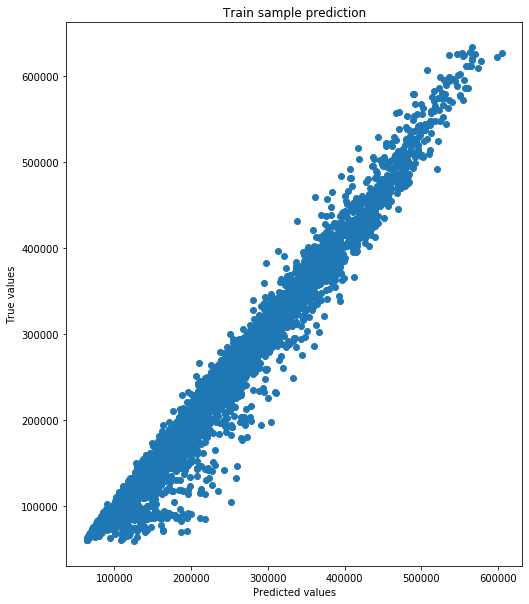

In [17]:
evaluate_predictions(y_train, y_train_preds, y_val, y_val_preds)

In [18]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.210239
19,PricePerSquare_mean_by_DistrictId,0.143028
2,LifeSquare,0.125171
0,Rooms,0.098873
14,DistrictSize,0.074169
3,KitchenSquare,0.051392
9,Social_2,0.044055
8,Social_1,0.039585
6,HouseYear,0.036484
10,Social_3,0.032716


In [19]:
if y_val is not None:
    X_val2 = copy_for_analysis(X_val, y_val, y_val_preds)
    X_train2 = copy_for_analysis(X_train, y_train, y_train_preds)
    print_errors_df(X_val2)
    plot_prices(X_val2, 'DistrictId', X_val2['PredictedPrice'])
    display(X_val2.corr()[['RelativeError']].sort_values(by='RelativeError', ascending=False))

**Дополнительные режимы подбора параметров и кросс-валидации**

In [20]:
from sklearn.model_selection import RandomizedSearchCV

def predict_and_r2(df):
    tx = test_df[feature_names]
    tpy = model.predict(tx)
    ty = test_df[target_name] 
    return r2(ty, tpy)

def search_parameters():
    parameters = {
     'bootstrap': [True, False],
     'max_depth': [None, 10, 30, 100],
     'max_features': ['sqrt'],
     'min_samples_leaf': [1, 2, 3],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [100, 150, 200, 250, 300, 500, 1000],
     'oob_score': [True, False]
    }

    clf = RandomizedSearchCV(
        estimator=RandomForestRegressor(),
        param_distributions = parameters, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 4,
        scoring='r2'
    )
    clf.fit(X, y)

    cv_results = pd.DataFrame(clf.cv_results_)

    return cv_results.sort_values(by='mean_test_score', ascending=False)

if use_parameter_search:
    spr = search_parameters() # 
    display(spr)

In [21]:
if use_cross_validation:
    cv_score = cross_val_score(model, X, y, 
            scoring='r2',
            cv=KFold(n_splits=5, shuffle=True, random_state=21))
    print(cv_score)
    print(cv_score.mean())

**Получиение, просмотр, и запись предсказаний на тестовых данных**

In [22]:
X_test = test_df[feature_names]
y_test_preds = model.predict(X_test)

In [23]:
if target_name in test_df.columns:
    y_test = test_df[target_name] 
    X_test2 = copy_for_analysis(X_test, y_test, y_test_preds)
    print_errors_df(X_test2)

In [24]:
test_df['Price'] = y_test_preds.round(4)
test_df.to_csv(TEST_PREDICTION_PATH, columns=['Id', 'Price'], index=False)